# Anomaly Detection and Localization with PaDiM - summary
Author: Nikolay Chehlarov
date: 28.01.2022

paper: PaDiM: a Patch Distribution Modeling Framework for Anomaly Detection and Localization

authors: Thomas Defard, Aleksandr Setkov, Angelique Loesch, Romaric Audigier Universit´e Paris-Saclay, CEA, List, F-91120, Palaiseau, France

Link to paper: https://arxiv.org/abs/2011.08785

# Abstract

Many industrial applications require optical inspection of all produced parts. Often the inspection is done by human, following the instructions of a failure catalog. There are several disadvantages for such approach. 

An alternative, with several benefits, is to use AOI (automated optical inspection). PaDiM is an example of architecture to detect anomalies in picture. As of 28.01.2022 it is ranked 6 place on the MVTec AD dataset - https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad.  MVTec AD dataset is focused on industrial applications and contains train and test sets in several domains. Source of anomalies can vary a lot, for example foreign particle location. Supervised learning is not possible, because not all outliers could be collected or simulated.

# PaDiM highlights:
- trained only on normal images (one-class learning setting)
- detects and localizes the anomalies
- localizations improves interpretability
- ranked 6 on Anomaly Detection on MVTec AD (as of 28.01.2022)
- uses pretrained convolutional neural network (no CNN training needed)
- low complexity, good scalability
- Multivariate Gaussian distributions (https://www.youtube.com/watch?v=6W2mkOfzitk) is used to detect out of normality samples

Example output is shown below.

![](figures/figure1.png)

# Comparison to other approaches

There are two approaches for anomaly detection:
- reconstruction based
    - Autoencoders, variation autoencoders or generative adversarial networks
    - very intuitive and interpretable, but their performance is limited by the fact that AE can sometimes yield good reconstruction results for anomalous images too - https://arxiv.org/abs/1903.08550. 
- embedding similarity based
    - difficult to interpret, localization of the anomaly is often not known.
    - The anomaly score is in this case the distance between embedding vectors of a test image and reference vectors  representing normality from the training dataset.
    - SPADE is one good model based on this approaches, however it runs a K-NN algorithm on a set of normal embedding vectors at test time, so the inference complexity scales linearly to the dataset training size.
- the normal class in PaDiM is described through a set of Gaussian distributions that also model correlations between semantic levels of the used pretrained CNN model.

# Methods

- using a pre-trained CNN to generate patch embedding vectors. Embedding is done by either ResNet18 / Wide-ResNet-50-2 / EfficientNet-B5. Backbone is pretrained on ImageNet
- Activation vectors from different layers are concatenated. Information from different semantic levels and resolutions is collected. Fine grained and global contexts are encoded.
- The generated patch embedding vectors carry redundant information, randomly selecting few dimensions is more effective than PCA. This approach significantly reduces complexity, while maintaining the state-of-the-art performance
- It is assumed that the patch embedding vectors are generated by a multivariate Gaussian distribution the sample covariance is estimated as follows :
$$Σ_{ij}=\frac{1}{N-1}\sum_{k=1}^{N}(x_{ij}^k-µ_{ij})(x_{ij}^k-µ_{ij})^{T}+\epsilon I$$ where $µ_{ij}$ is the sample mean of $x_{ij}$; $\epsilon I$ is regularisation term that makes covariance matrix invertible.
- During inference, Mahalanobis distance is used to give an anomaly score for each embedded patch $x_{ij}$. The distance is calculated by $$M(x_{ij})=\sqrt{(x_{ij}-µ_{ij})^{T}Σ_{ij}^{-1}(x_{ij}-µ_{ij})}$$
- Next map of Mahalanobis distances is created to indicate anomalous areas. The anomaly score is the maximum of the anomaly map.
- AUROC is used to as a metric. This metric is threshold independent. PRO-score is also used.
- Testing is done on MVTec AD dataset, designed to test anomaly localization algorithms. Rd-MVTec AD dataset is created my small rotation and cropping to better assess the performance, when images are not perfectly aligned. Shanghai Tech Campus (STC) Dataset is also used.

# Experiments done in the paper

Different backbones are used, all trained on ImageNet:
- ResNet18
    - embedding vectors used from layers: 1, 2, 3
- Wide ResNet-50-2
    - embedding vectors used from layers: 1, 2, 3
- EfficientNet-B5
    - embedding vectors used from layers: 7, 20, 26
    
Dimensionality reduction is done; the number of selected dimensions is labeled after Rd. Be default $\epsilon=0.01$

All images are resized to 256x256 and cropped to 224x224.

It is demonstrated that taking into consideration the correlation between different layers improve the performance. Dimensionality reduction is compared between PCA and random (Rd); random dimensionality reduction produces better scores than PCA. It is demonstrated that PaDiM is more robust towards non-aligned images (random small rotations). Speed for training and inference is several times faster compared to competitors.

# Implementation

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf

In [2]:
import matplotlib
import matplotlib.pyplot as plt

from skimage import morphology
from skimage.segmentation import mark_boundaries

In [3]:
import sklearn.metrics as metrics
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import mahalanobis

In [4]:
class MVTecADLoader(object):
    """
    Class for managing the data
    """
    base_path = r'mvtec_ad'


    train, test = None, None
    num_train, num_test = 0, 0

    category = {'bottle': ['good', 'broken_large', 'broken_small', 'contamination'],
                'cable': ['good', 'bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation',
                          'missing_cable', 'missing_wire', 'poke_insulation'],
                'capsule': ['good', 'crack', 'faulty_imprint', 'poke', 'scratch', 'squeeze'],
                'carpet': ['good', 'color', 'cut', 'hole', 'metal_contamination', 'thread'],
                'grid': ['good', 'bent', 'broken', 'glue', 'metal_contamination', 'thread'],
                'hazelnut': ['good', 'crack', 'cut', 'hole', 'print'],
                'leather': ['good', 'color', 'cut', 'fold', 'glue', 'poke'],
                'metal_nut': ['good', 'bent', 'color', 'flip', 'scratch'],
                'pill': ['good', 'color', 'combined', 'contamination', 'crack', 'faulty_imprint', 'pill_type',
                         'scratch'],
                'screw': ['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top'],
                'tile': ['good', 'crack', 'glue_strip', 'gray_stroke', 'oil', 'rough'],
                'toothbrush': ['good', 'defective'],
                'transistor': ['good', 'bent_lead', 'cut_lead', 'damaged_case', 'misplaced'],
                'wood': ['good', 'color', 'combined', 'good', 'hole', 'liquid', 'scratch'],
                'zipper': ['good', 'broken_teeth', 'combined', 'fabric_border', 'fabric_interior', 'rough',
                           'split_teeth', 'squeezed_teeth']}

    def setup_base_path(self, path):
        self.base_path = path

    def load(self, category, repeat=4, max_rot=10):
        """
        Loads the images
        """
        # data, mask, binary anomaly label; (0 for anomaly, 1 for good)
        x, y, z = [], [], []

        # Load train set
        path = os.path.join(os.path.join(self.base_path, category), 'train\good')
        files = os.listdir(path)

        zero_mask = tf.zeros(shape=(224, 224), dtype=tf.int32)

        for rdx in range(repeat):
            for _files in files:
                full_path = os.path.join(path, _files)
                img = self._read_image(full_path=full_path)

                if not max_rot == 0:
                    img = tf.keras.preprocessing.image.random_rotation(img, max_rot)

                mask = zero_mask

                x.append(img)
                y.append(mask) # no anomaly pixels
                z.append(1) # 1 for good

        x = np.asarray(x)
        y = np.asarray(y)
        self.num_train = len(x)

        x = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(x, dtype=tf.float32))
        y = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(y, dtype=tf.int32))
        z = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(z, dtype=tf.int32))

        self.train = tf.data.Dataset.zip((x, y, z))

        # data, anomaly label (e.g., good, cut, ..., etc.), binary anomaly label (0 for anomaly, 1 for good)
        x, y, z = [], [], []

        # Load test set
        for _label in self.category[category]:
            path = os.path.join(os.path.join(self.base_path, category), f'test\\{_label}')

            files = os.listdir(path)
            for _files in files:
                full_path = os.path.join(path, _files)
                img = self._read_image(full_path=full_path)

                if _label == 'good':
                    mask = zero_mask
                else:
                    mask_path = os.path.join(os.path.join(self.base_path, category), 'ground_truth/{}'.format(_label))
                    _mask_path = os.path.join(mask_path, '{}_mask.png'.format(_files.split('.')[0]))
                    mask = cv2.resize(cv2.imread(_mask_path, flags=cv2.IMREAD_GRAYSCALE), dsize=(256, 256)) / 255
                    mask = mask[16:-16, 16:-16]
                    mask = tf.convert_to_tensor(mask, dtype=tf.int32)

                x.append(img)
                y.append(mask)
                z.append(int(self.category[category].index(_label) == 0))

        x = np.asarray(x)
        y = np.asarray(y)
        self.num_test = len(x)

        x = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(x, dtype=tf.float32))
        y = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(y, dtype=tf.int32))
        z = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(z, dtype=tf.int32))

        self.test = tf.data.Dataset.zip((x, y, z))

    @staticmethod
    def _read_image(full_path, flags=cv2.IMREAD_COLOR):
        """
        Loads, resize and crops and image
        """
        img = cv2.imread(full_path, flags=flags)
        b, g, r = cv2.split(img)
        img = cv2.merge([r, g, b])

        img = cv2.resize(img, dsize=(256, 256))

        img = img[16:-16, 16:-16, :]

        return img

In [5]:
def embedding_concat(l1, l2):
    """
    input: two layers; the two layers can diffrent shape
    result: concatanated layer; features are stacked in depth (z dimension)
    """
    bs, h1, w1, c1 = l1.shape
    _, h2, w2, c2 = l2.shape

    s = int(h1 / h2)
    x = tf.compat.v1.extract_image_patches(l1,
                                           ksizes=[1, s, s, 1],
                                           strides=[1, s, s, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
    x = tf.reshape(x, (bs, -1, h2, w2, c1))

    col_z = []
    for idx in range(x.shape[1]):
        col_z.append(tf.concat([x[:, idx, :, :, :], l2], axis=-1))
    z = tf.stack(col_z, axis=1)

    z = tf.reshape(z, (bs, h2, w2, -1))
    if s == 1:
        return z
    z = tf.nn.depth_to_space(z, block_size=s)

    return z


def plot_fig(test_img, scores_in, gts, threshold, save_dir, class_name, num_random_plot=0):
    """
    Creates preview for assesing the performance. Preview images are saved to directory. 
    Every preview consists of 5 images
    """
    scores = scores_in.copy() # in range [0, 1]
    num = len(scores)
    vmax = scores.max() * 1
    vmin = scores.min() * 1
    for i in range(num):
        img = test_img[i][0]

        gt = gts[i].transpose(1, 2, 0).squeeze()

        heat_map = scores[i] * 1
        mask = scores[i]
        mask[mask > threshold] = 1
        mask[mask <= threshold] = 0

        kernel = morphology.disk(4)
        mask = morphology.opening(mask, kernel)
        mask *= 255
        vis_img = mark_boundaries(img, mask, color=(1, 0, 0), mode='thick')
        fig_img, ax_img = plt.subplots(1, 5, figsize=(12, 3), dpi=200)
        fig_img.subplots_adjust(right=0.9)
        # norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
        ax_img[0].imshow(img.astype(int))
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(gt.astype(int), cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax = ax_img[2].imshow(heat_map, cmap='jet', vmin=vmin, vmax=vmax) # norm=norm
        # ax_img[2].imshow(img.astype(int), cmap='gray', interpolation='none')
        # ax_img[2].imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none')
        ax_img[2].title.set_text('Predicted heat map')
        ax_img[3].imshow(mask.astype(int), cmap='gray')
        ax_img[3].title.set_text('Predicted mask')
        ax_img[4].imshow(vis_img.astype(int))
        ax_img[4].title.set_text('Segmentation result')
        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
        cb.ax.tick_params(labelsize=8)
        font = {
            'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
        }
        cb.set_label('Anomaly Score', fontdict=font)
        
        if np.random.random() < num_random_plot / num:
            plt.show()

        fig_img.savefig(os.path.join(save_dir, class_name + '_{}'.format(i)), dpi=100)
        plt.close()


def draw_auc(fp_list, tp_list, auc, path, mode='save'):
    """
    Draw and save AUROC - area under ROC
    """
    plt.figure()
    plt.plot(fp_list, tp_list, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    if mode == 'save':
        plt.savefig(path)
        plt.clf()
        plt.cla()
        plt.close()
    elif mode == 'show':
        plt.show()


def draw_precision_recall(precision, recall, base_line, path, mode='save'):
    """
    Draw and save preition - recall curve
    returns the maximum f1 score from all images
    """
    f1_score = []
    for _idx in range(0, len(precision)):
        _precision = precision[_idx]
        _recall = recall[_idx]

        if _precision + _recall == 0:
            _f1 = 0
        else:
            _f1 = 2 * (_precision * _recall) / (_precision + _recall)
        f1_score.append(_f1)

    plt.figure()
    plt.plot(recall, precision, marker='.', label='precision-recall curve')
    plt.plot([0, 1], [base_line, base_line], linestyle='--', color='grey', label='No skill ({:.04f})'.format(base_line))
    plt.plot(recall, f1_score, linestyle='-', color='red', label='f1 score (Max.: {:.4f})'.format(np.max(f1_score)))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    if mode == 'save':
        plt.savefig(path)
        plt.clf()
        plt.cla()
        plt.close()
    elif mode == 'show':
        plt.show()
        
    return np.max(f1_score)

In [6]:
# input_tensor = tf.keras.layers.Input([224, 224, 3], dtype=tf.float32)
# x = tf.keras.applications.efficientnet.preprocess_input(input_tensor)
# model = tf.keras.applications.EfficientNetB5(include_top=False, weights='imagenet', input_tensor=x, pooling=None)
# model.summary()

In [7]:
def embedding_net(net_type='res'):
    """
    creates an embedding netowork. The backbone of the netowrk can be selected by net_type
    returns 3 layers of interest 
    """
    input_tensor = tf.keras.layers.Input([224, 224, 3], dtype=tf.float32)

    if net_type == 'res':
        # resnet 50v2; https://arxiv.org/abs/1603.05027
        x = tf.keras.applications.resnet_v2.preprocess_input(input_tensor)
        model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=x, pooling=None)

        # layer1 = model.get_layer(name='conv3_block1_preact_relu').output
        # layer2 = model.get_layer(name='conv4_block1_preact_relu').output
        # layer3 = model.get_layer(name='conv5_block1_preact_relu').output
        layer1 = model.get_layer(name='conv2_block3_2_relu').output
        layer2 = model.get_layer(name='conv3_block4_2_relu').output
        layer3 = model.get_layer(name='conv4_block6_2_relu').output
        
    elif net_type == 'eff_net1':
        # efficient net B7;
        x = tf.keras.applications.efficientnet.preprocess_input(input_tensor)
        model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=x,
                                                     pooling=None)

        layer1 = model.get_layer(name='block5a_expand_activation').output
        layer2 = model.get_layer(name='block6a_expand_activation').output
        layer3 = model.get_layer(name='block7a_expand_activation').output
    
    elif net_type == 'eff_net2':
        # efficient net B7; should be best model for carpet
        x = tf.keras.applications.efficientnet.preprocess_input(input_tensor)
        model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=x,
                                                     pooling=None)

        layer1 = model.get_layer(name='block4a_expand_activation').output
        layer2 = model.get_layer(name='block6a_expand_activation').output
        layer3 = model.get_layer(name='block7a_expand_activation').output
        
    elif net_type == 'eff_net3':
        # efficient net B7
        x = tf.keras.applications.efficientnet.preprocess_input(input_tensor)
        model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=x, pooling=None)

        layer1 = model.get_layer(name='block5a_activation').output
        layer2 = model.get_layer(name='block6a_activation').output
        layer3 = model.get_layer(name='block7a_activation').output
        
    elif net_type == 'effB5':
        # suggested in the paper
        # efficient net B5; https://arxiv.org/abs/1905.11946
        x = tf.keras.applications.efficientnet.preprocess_input(input_tensor)
        model = tf.keras.applications.EfficientNetB5(include_top=False, weights='imagenet', input_tensor=x, pooling=None)

        layer1 = model.get_layer(name='block2a_activation').output
        layer2 = model.get_layer(name='block4a_activation').output
        layer3 = model.get_layer(name='block5a_activation').output

    else:
        raise Exception("[NotAllowedNetType] network type is not allowed ")

    model.trainable = False
    # model.summary(line_length=100)
    shape = (layer1.shape[1], layer1.shape[2], layer1.shape[3] + layer2.shape[3] + layer3.shape[3])

    return tf.keras.Model(model.input, outputs=[layer1, layer2, layer3]), shape

In [8]:
def padim(category, batch_size, rd, net_type='eff', is_plot=False):
    """
    Function to test the model performance with diffrent settings
    """
    loader = MVTecADLoader()
    loader.load(category=category, repeat=1, max_rot=0)

    train_set = loader.train.batch(batch_size=batch_size, drop_remainder=True).shuffle(buffer_size=loader.num_train,
                                                                                       reshuffle_each_iteration=True)
    test_set = loader.test.batch(batch_size=1, drop_remainder=False)

    net, _shape = embedding_net(net_type=net_type)
    h, w, c = _shape  # height and width of layer1, channel sum of layer 1, 2, and 3, and randomly sampled dimension

    out = [] # list of embedding train vectors
    for x, _, _ in train_set:
        l1, l2, l3 = net(x)
        _out = tf.reshape(embedding_concat(embedding_concat(l1, l2), l3),
                          (batch_size, h * w, c) # (b, h x w, c)
                         )  
        out.append(_out.numpy())

    # calculate multivariate Gaussian distribution.
    out = np.concatenate(out, axis=0)
    out = np.transpose(out, axes=[0, 2, 1])  # (b, c, h * w)

    # random dimension selecting
    tmp = tf.unstack(out, axis=0)
    _tmp = []
    rd_indices = tf.random.shuffle(tf.range(c))[:rd]
    for tensor in tmp:
        _tmp.append(tf.gather(tensor, rd_indices))
    out = tf.stack(_tmp, axis=0) # randomly selected dimensions

    mu = np.mean(out, axis=0)
    cov = np.zeros((rd, rd, h * w))
    identity = np.identity(rd)

    for idx in range(h * w):
        cov[:, :, idx] = np.cov(out[:, :, idx], rowvar=False) + 0.01 * identity

    train_outputs = [mu, cov] # shape (400, 196), (400, 400, 196)

    # inference
    out, gt_list, gt_mask, batch_size, test_imgs = [], [], [], 1, []
    #  x - data; y - mask; z - binary label
    for x, y, z in test_set:
        test_imgs.append(x.numpy())
        gt_mask.append(y.numpy())
        gt_list.append(z.numpy())

        l1, l2, l3 = net(x)
        _out = tf.reshape(embedding_concat(embedding_concat(l1, l2), l3),
                          (batch_size, h * w, c))  # (BS, h x w, c)
        out.append(_out.numpy())

    # calculate multivariate Gaussian distribution
    out = np.concatenate(out, axis=0)
    gt_list = np.concatenate(gt_list, axis=0) # 1 - good, 0 - anomal
    out = np.transpose(out, axes=[0, 2, 1]) # (b, c, h * w)

    # random dimension selecting
    tmp = tf.unstack(out, axis=0)
    _tmp = []
    for tensor in tmp:
        _tmp.append(tf.gather(tensor, rd_indices))
    out = tf.stack(_tmp, axis=0)

    b, _, _ = out.shape

    dist_list = []  # Mahalanobis distances
    for idx in range(h * w):
        mu = train_outputs[0][:, idx]
        cov_inv = np.linalg.inv(train_outputs[1][:, :, idx])
        dist = [mahalanobis(sample[:, idx], mu, cov_inv) for sample in out]
        dist_list.append(dist)

    dist_list = np.reshape(np.transpose(np.asarray(dist_list),
                                        axes=[1, 0]),
                           (b, h, w)) # (117, 14, 14), float, positive only

    ###   DATA Level, predicting the image class good/bad ###
    # upsample
    # score_map = tf.squeeze(tf.image.resize(np.expand_dims(dist_list, -1), size=[h, w])).numpy() # doesn't do anything, only changes from float64 to float32
    score_map = tf.cast(dist_list, tf.float32)
    score_map = score_map.numpy() # high score means it is outlier
    
    for i in range(score_map.shape[0]):
        score_map[i] = gaussian_filter(score_map[i], sigma=4) # this smoothing is quite aggresive for 14x14, but if removed the score is much worse

    # Normalization
    max_score = score_map.max()
    min_score = score_map.min()
    scores = (score_map - min_score) / (max_score - min_score)
    scores = -scores # scores in range -1 to 0; -1 means anomal picture, 0 - OK picture; mode close to 0


    # calculate image-level ROC AUC score
    img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)

    gt_list = np.asarray(gt_list)  # 1 - OK, 0 - anomal
    img_roc_auc = metrics.roc_auc_score(gt_list, img_scores) # AUROC metric on image level

    if is_plot is True:
        fpr, tpr, _ = metrics.roc_curve(gt_list, img_scores)
        precision, recall, _ = metrics.precision_recall_curve(gt_list, img_scores)

        save_dir = os.path.join(os.getcwd(), 'img')
        if os.path.isdir(save_dir) is False:
            os.mkdir(save_dir)
        draw_auc(fpr, tpr, img_roc_auc, os.path.join(save_dir, 'AUROC-{}.png'.format(category)))
        base_line = np.sum(gt_list) / len(gt_list)
        draw_precision_recall(precision, recall, base_line, os.path.join(os.path.join(save_dir,
                                                                                      'PR-{}.png'.format(category))))
    ###   Localization Level ###
    # upsample
    score_map = tf.squeeze(
                            tf.image.resize(
                                            np.expand_dims(dist_list, -1),
                                            size=[224, 224])
                           ).numpy()

    for i in range(score_map.shape[0]):
        score_map[i] = gaussian_filter(score_map[i], sigma=4)

    # Normalization
    max_score = score_map.max()
    min_score = score_map.min()
    scores = (score_map - min_score) / (max_score - min_score)
    scores_raw = scores
    # high score means high Mahalanobis distance
    # Note that Binary mask indicates 0 for good and 1 for anomaly. It is opposite from our setting.
    # scores = -scores

    # calculate per-pixel level ROCAUC
    gt_mask = np.asarray(gt_mask)
    fp_list, tp_list, _ = metrics.roc_curve(gt_mask.flatten(), scores.flatten())
    patch_auc = metrics.auc(fp_list, tp_list)

    precision, recall, threshold = metrics.precision_recall_curve(gt_mask.flatten(),
                                                                  scores.flatten(),
                                                                  pos_label=1)
    numerator = 2 * precision * recall
    denominator = precision + recall

    numerator[denominator == 0] = 0
    denominator[denominator == 0] = 1

    # get optimal threshold
    f1_list = numerator / denominator
    best_ths = threshold[np.argmax(f1_list).astype(int)]

    print(f'[{category}] image ROCAUC: {img_roc_auc:.04f}\t pixel ROCAUC: {patch_auc:.04f}')

    if is_plot is True:
        save_dir = os.path.join(os.getcwd(), 'img')
        if os.path.isdir(save_dir) is False:
            os.mkdir(save_dir)
        plot_fig(test_imgs, scores, gt_mask, best_ths, save_dir, category)

#     return img_roc_auc, patch_auc
    return test_imgs, scores, gt_mask, best_ths, save_dir, category, scores_raw

# Running the process step by step 

In [9]:
np.random.seed(10)
tf.random.set_seed(10)
category='carpet'
batch_size=8
rd=400
net_type='eff_net1'
is_plot=True

In [10]:
loader = MVTecADLoader()
loader.load(category=category, repeat=1, max_rot=0)

train_set = loader.train.batch(batch_size=batch_size, drop_remainder=True).shuffle(buffer_size=loader.num_train,
                                                                                   reshuffle_each_iteration=True)
test_set = loader.test.batch(batch_size=1, drop_remainder=False)

net, _shape = embedding_net(net_type=net_type)
h, w, c = _shape  # height and width of layer1, channel sum of layer 1, 2, and 3, and randomly sampled dimension

out = [] # list of embedding train vectors
for x, _, _ in train_set:
    l1, l2, l3 = net(x)
    _out = tf.reshape(embedding_concat(embedding_concat(l1, l2), l3),
                      (batch_size, h * w, c) # (b, h x w, c)
                     )  
    out.append(_out.numpy())

# calculate multivariate Gaussian distribution.
out = np.concatenate(out, axis=0)
out = np.transpose(out, axes=[0, 2, 1])  # (b, c, h * w)

# random dimension selecting
tmp = tf.unstack(out, axis=0)
_tmp = []
rd_indices = tf.random.shuffle(tf.range(c))[:rd]
for tensor in tmp:
    _tmp.append(tf.gather(tensor, rd_indices))
out = tf.stack(_tmp, axis=0) # randomly selected dimensions

mu = np.mean(out, axis=0)
cov = np.zeros((rd, rd, h * w))
identity = np.identity(rd)

for idx in range(h * w):
    cov[:, :, idx] = np.cov(out[:, :, idx], rowvar=False) + 0.01 * identity

train_outputs = [mu, cov] # shape (400, 196), (400, 400, 196)

In [11]:
mu.shape, cov.shape

((400, 196), (400, 400, 196))

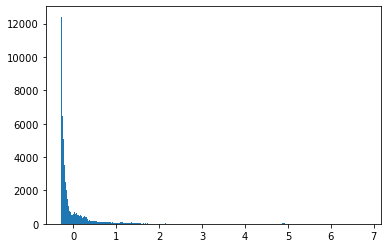

In [12]:
plt.hist(mu.ravel(), bins="fd")
plt.show()

In [13]:
# inference
out, gt_list, gt_mask, batch_size, test_imgs = [], [], [], 1, []
#  x - data; y - mask; z - binary label
for x, y, z in test_set:
    test_imgs.append(x.numpy())
    gt_mask.append(y.numpy())
    gt_list.append(z.numpy())

    l1, l2, l3 = net(x)
    _out = tf.reshape(embedding_concat(embedding_concat(l1, l2), l3),
                      (batch_size, h * w, c))  # (BS, h x w, c)
    out.append(_out.numpy())

# calculate multivariate Gaussian distribution
out = np.concatenate(out, axis=0)
gt_list = np.concatenate(gt_list, axis=0) # 1 - good, 0 - abnormal
out = np.transpose(out, axes=[0, 2, 1]) # (b, c, h * w)

# random dimension selecting
tmp = tf.unstack(out, axis=0)
_tmp = []
for tensor in tmp:
    _tmp.append(tf.gather(tensor, rd_indices))
out = tf.stack(_tmp, axis=0)

b, _, _ = out.shape

dist_list = []  # Mahalanobis distances
for idx in range(h * w):
    mu = train_outputs[0][:, idx]
    cov_inv = np.linalg.inv(train_outputs[1][:, :, idx])
    dist = [mahalanobis(sample[:, idx], mu, cov_inv) for sample in out]
    dist_list.append(dist)

dist_list = np.reshape(np.transpose(np.asarray(dist_list),
                                    axes=[1, 0]),
                       (b, h, w))

In [14]:
out.shape

TensorShape([117, 400, 196])

In [15]:
dist_list.shape

(117, 14, 14)

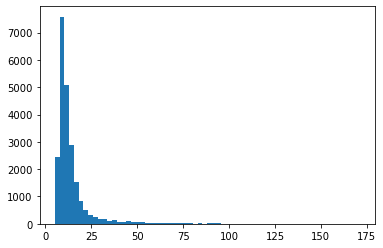

In [16]:
plt.hist(dist_list.ravel(), bins=64)
# plt.ylim(0, 1000)
plt.show()

###   DATA Level, predicting the image class good/abnormal

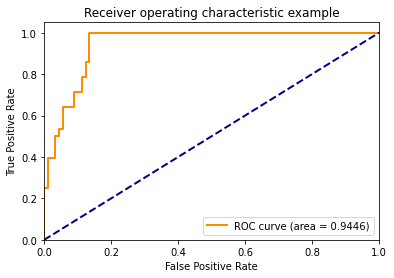

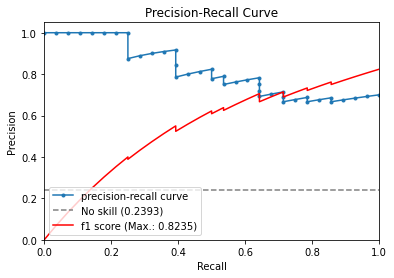

In [17]:
# upsample
# score_map = tf.squeeze(tf.image.resize(np.expand_dims(dist_list, -1), size=[h, w])).numpy() # doesn't do anything, only changes from float64 to float32
score_map = tf.cast(dist_list, tf.float32)
score_map = score_map.numpy() # high score means it is outlier

for i in range(score_map.shape[0]):
    score_map[i] = gaussian_filter(score_map[i], sigma=4) # this smoothing is quite aggresive for 14x14, but if removed the score is much worse

# Normalization
max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)
scores = -scores # scores in range -1 to 0; -1 means abnormal picture, 0 - OK picture; mode of distribution close to 0

# calculate image-level ROC AUC score
img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)

gt_list = np.asarray(gt_list) # 1 - OK, 0 - abnormal
img_roc_auc = metrics.roc_auc_score(gt_list, img_scores) # AUROC metric on image level

if is_plot is True:
    fpr, tpr, _ = metrics.roc_curve(gt_list, img_scores)
    precision, recall, _ = metrics.precision_recall_curve(gt_list, img_scores)

    save_dir = os.path.join(os.getcwd(), 'img')
    if os.path.isdir(save_dir) is False:
        os.mkdir(save_dir)
    draw_auc(fpr, tpr, img_roc_auc, os.path.join(save_dir, 'AUROC-{}.png'.format(category)), mode='show')
    base_line = np.sum(gt_list) / len(gt_list)
    draw_precision_recall(precision,
                          recall,
                          base_line,
                          os.path.join(os.path.join(save_dir,'PR-{}.png'.format(category))),
                          mode='show'
                         )

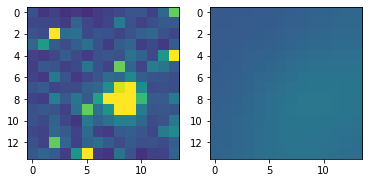

In [18]:
# demonstrate the aggresive gaussian smooth
plt.subplot(1, 2, 1)
plt.imshow(dist_list[35], vmin=0, vmax=50)
plt.subplot(1, 2, 2)
plt.imshow(score_map[35], vmin=0, vmax=50)
plt.show()

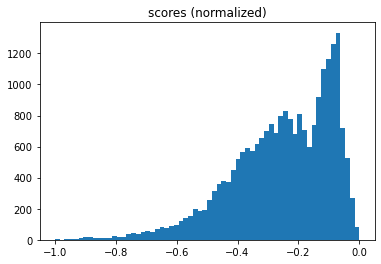

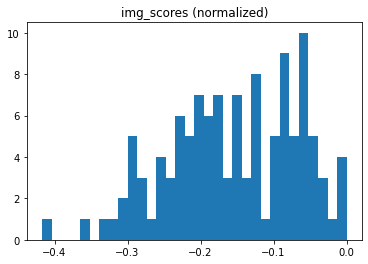

In [19]:
plt.hist(scores.ravel(), bins=64)
plt.title("scores (normalized)")
plt.show()
plt.hist(img_scores.ravel(), bins=32)
plt.title("img_scores (normalized)")
plt.show()

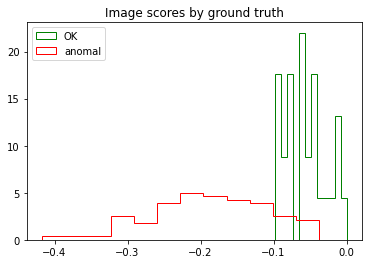

In [20]:
scores_ok = img_scores[gt_list == 1]
scores_anomal = img_scores[gt_list == 0]
plt.hist(scores_ok, bins=12, histtype='step', color='green', label='OK', density=True)
plt.hist(scores_anomal, bins=12, histtype='step', color='red', label='anomal', density=True)
plt.title("Image scores by ground truth")
plt.legend()
plt.show()

In [21]:
print(f"Image level AUROC = {img_roc_auc}")

Image level AUROC = 0.9446227929373997


###   Localization Level - finding abnormal areas

[carpet] image ROCAUC: 0.9446	 pixel ROCAUC: 0.9720


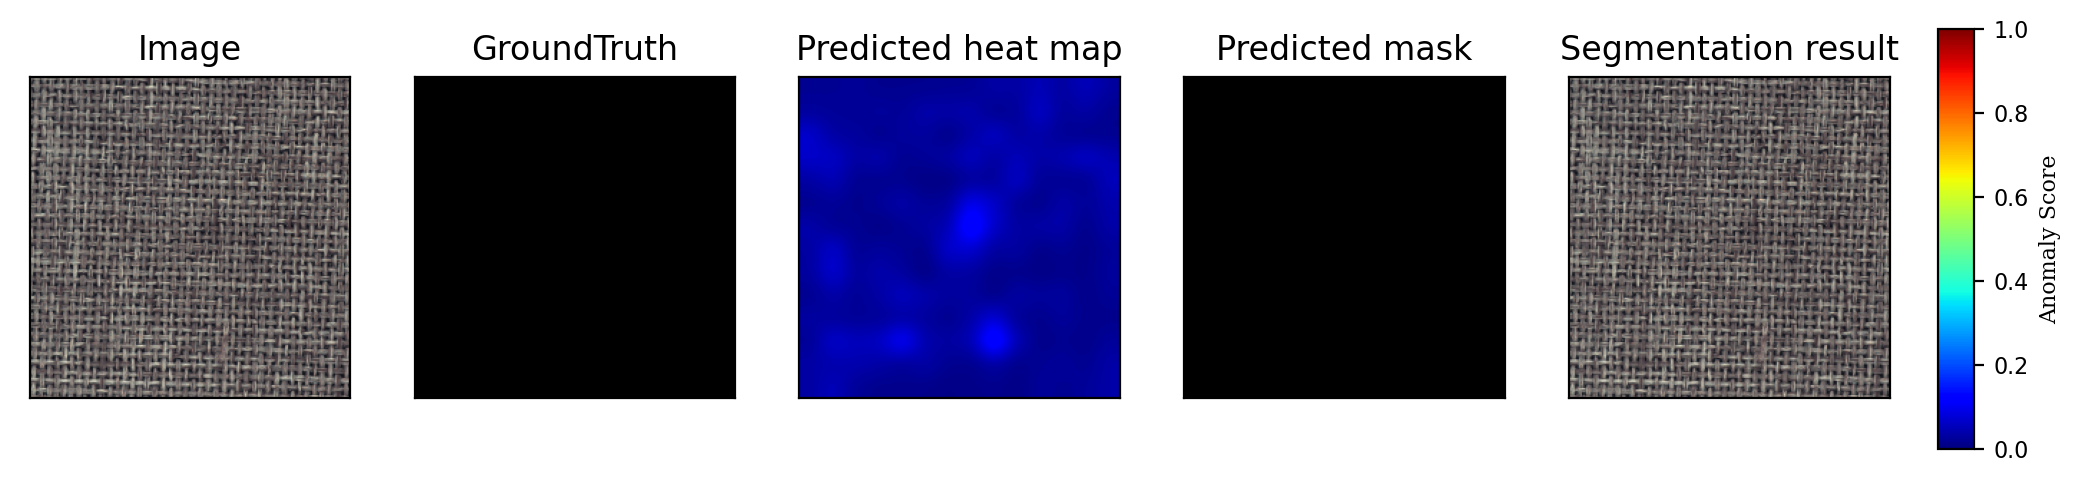

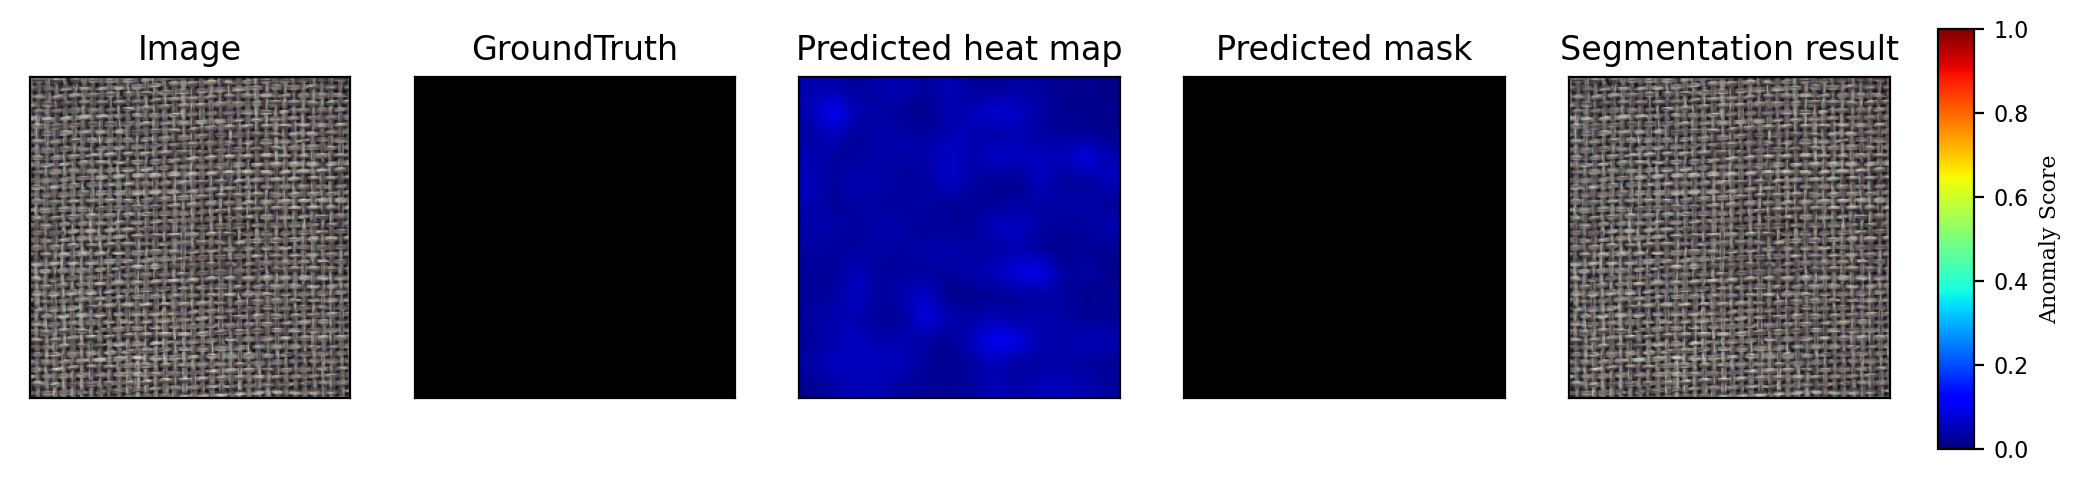

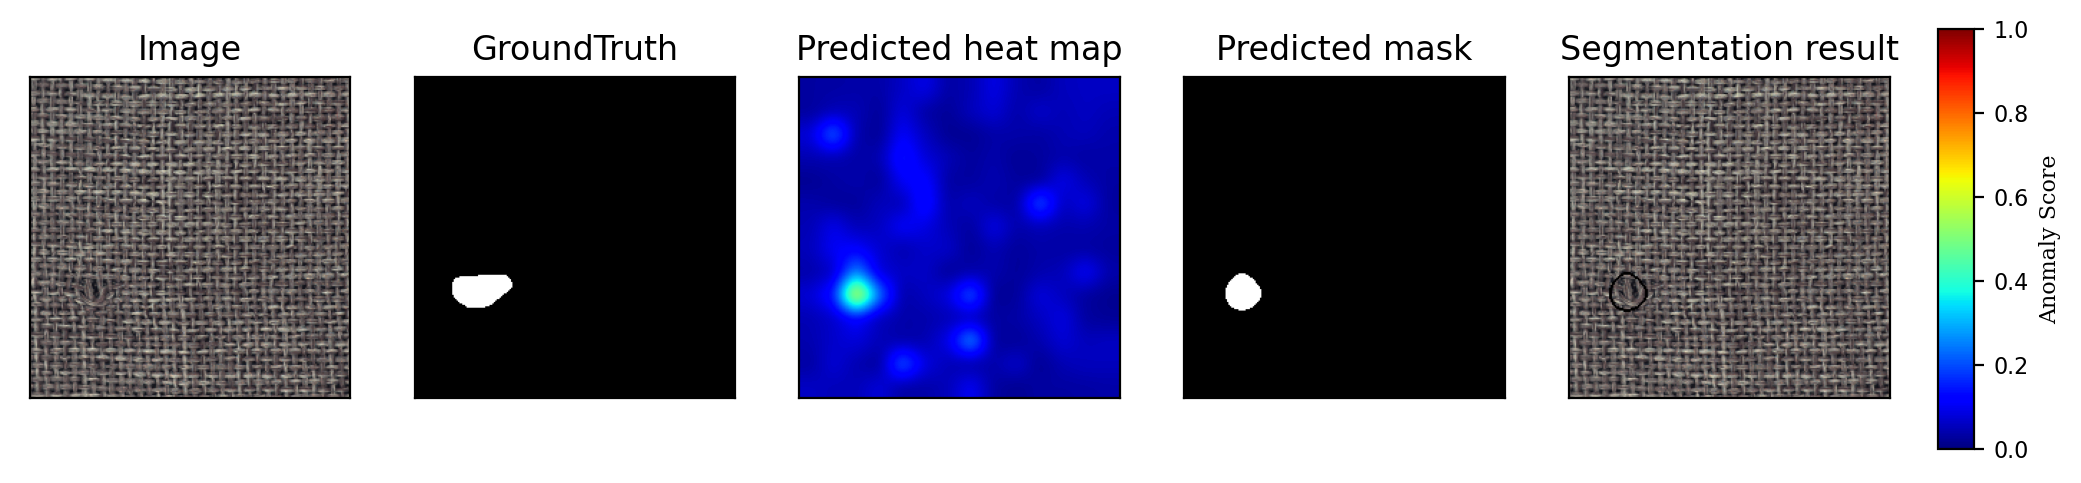

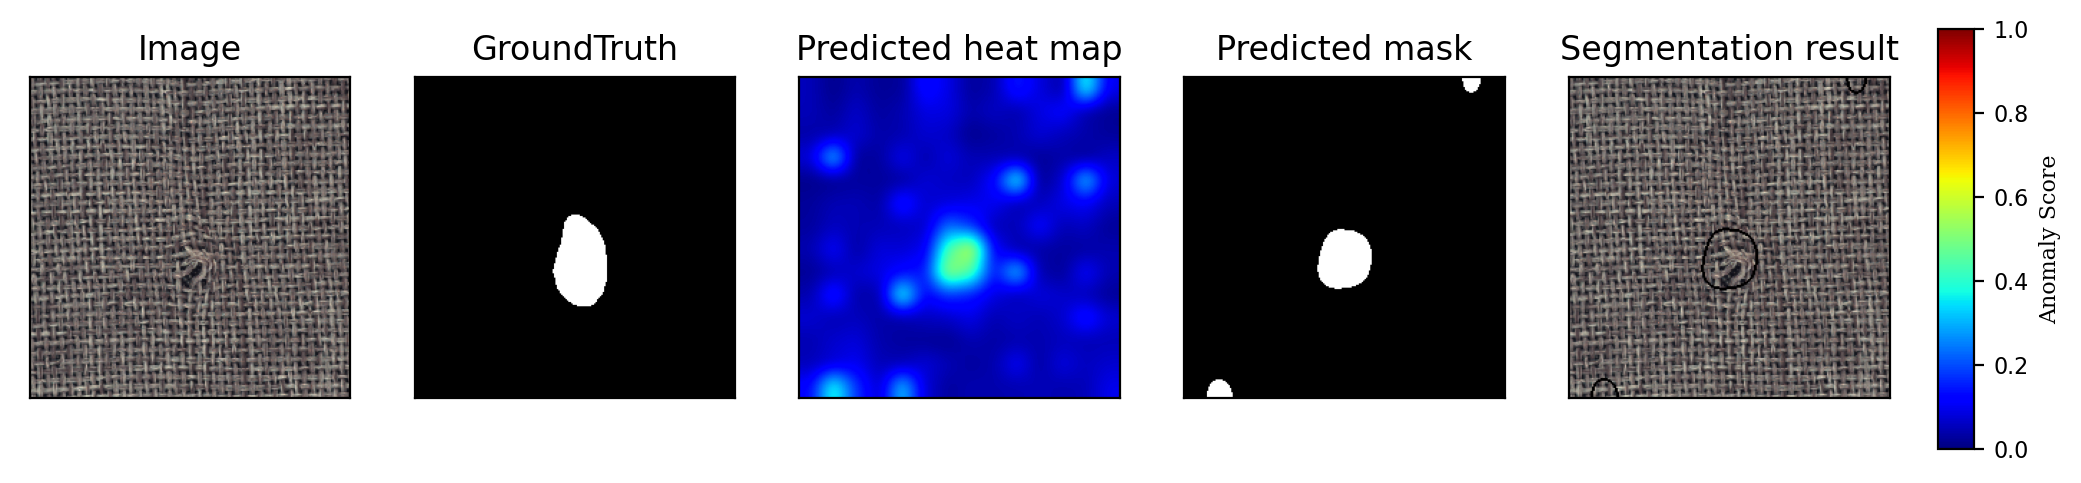

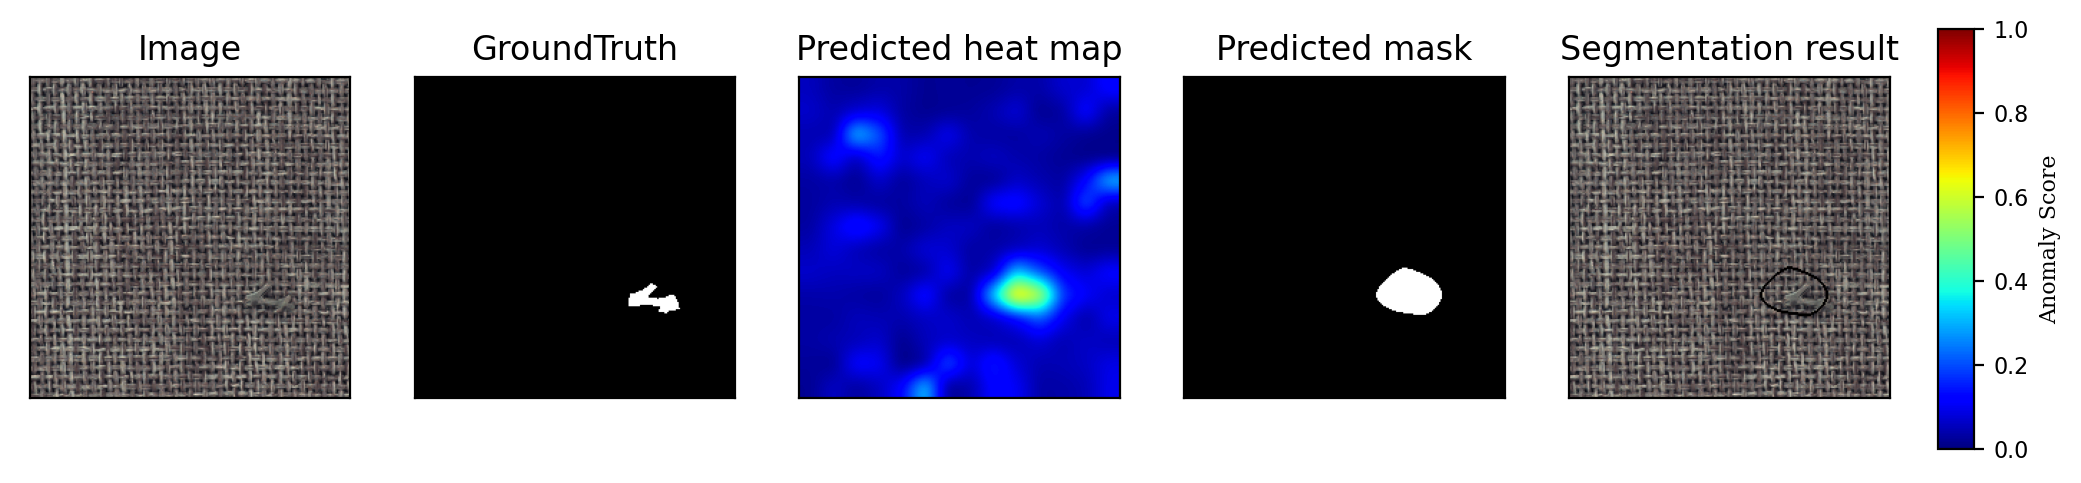

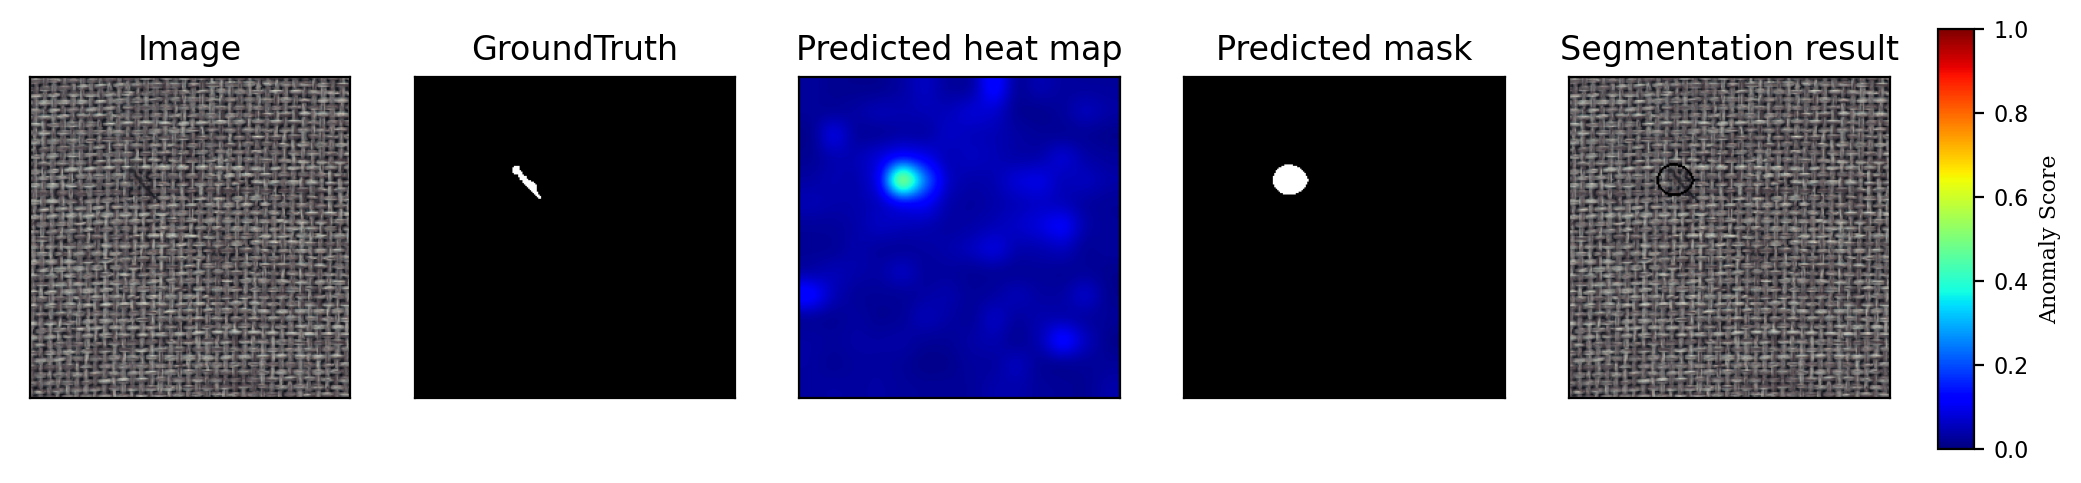

In [22]:
# upsample
score_map = tf.squeeze(tf.image.resize(
                                        np.expand_dims(dist_list, -1),
                                        size=[224, 224])
                       ).numpy()

for i in range(score_map.shape[0]):
    score_map[i] = gaussian_filter(score_map[i], sigma=4) 

# Normalization
max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)
# high score means high Mahalanobis distance; 
# Note that Binary mask indicates 0 for good and 1 for anomaly. 

# calculate per-pixel level ROCAUC
gt_mask = np.asarray(gt_mask)
fp_list, tp_list, _ = metrics.roc_curve(gt_mask.flatten(), scores.flatten())
patch_auc = metrics.auc(fp_list, tp_list)

precision, recall, threshold = metrics.precision_recall_curve(gt_mask.flatten(),
                                                              scores.flatten(),
                                                              pos_label=1)
# calculating f1 score
numerator = 2 * precision * recall
denominator = precision + recall
numerator[denominator == 0] = 0
denominator[denominator == 0] = 1
f1_list = numerator / denominator

# get optimal threshold - by maximizing f1 score;
# note the threshold needs information from the ground truth of the test set; this is not true test set
best_ths = threshold[np.argmax(f1_list).astype(int)]

print(f'[{category}] image ROCAUC: {img_roc_auc:.04f}\t pixel ROCAUC: {patch_auc:.04f}')

if is_plot is True:
    save_dir = os.path.join(os.getcwd(), 'img')
    if os.path.isdir(save_dir) is False:
        os.mkdir(save_dir)
    plot_fig(test_imgs, scores, gt_mask, best_ths, save_dir, category, 5)

All pictures can be found in img folder.

In [23]:
f1_list.max() # f1 of 0.52 is quite low

0.5243590296650993

In [24]:
scores_pix_ok = scores[np.squeeze(gt_mask) == 0]
scores_pix_anomal = scores[np.squeeze(gt_mask) != 0]

In [25]:
bins = [0.      , 0.015625, 0.03125 , 0.046875, 0.0625  , 0.078125,
        0.09375 , 0.109375, 0.125   , 0.140625, 0.15625 , 0.171875,
        0.1875  , 0.203125, 0.21875 , 0.234375, 0.25    , 0.265625,
        0.28125 , 0.296875, 0.3125  , 0.328125, 0.34375 , 0.359375,
        0.375   , 0.390625, 0.40625 , 0.421875, 0.4375  , 0.453125,
        0.46875 , 0.484375, 0.5     , 0.515625, 0.53125 , 0.546875,
        0.5625  , 0.578125, 0.59375 , 0.609375, 0.625   , 0.640625,
        0.65625 , 0.671875, 0.6875  , 0.703125, 0.71875 , 0.734375,
        0.75    , 0.765625, 0.78125 , 0.796875, 0.8125  , 0.828125,
        0.84375 , 0.859375, 0.875   , 0.890625, 0.90625 , 0.921875,
        0.9375  , 0.953125, 0.96875 , 0.984375, 1.      ]

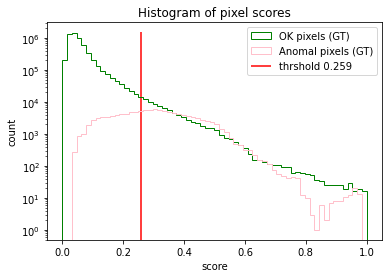

In [26]:
plt.hist(scores_pix_ok.ravel(), bins=bins, histtype='step', label="OK pixels (GT)", color='green')
plt.hist(scores_pix_anomal.ravel(), bins=bins, histtype='step', label="Anomal pixels (GT)", color='pink')
plt.vlines(best_ths, 0, 1500000, color='red', label=f"thrshold {best_ths:.3f}")
plt.yscale("log")
plt.title("Histogram of pixel scores")
plt.xlabel("score")
plt.ylabel("count")
plt.legend()
plt.show()

There is significant overlap of the Mahalanobis scores between OK and abnormal pixels. It is not possible to have good separation between good and abnormal pixels with this scores; however spatial information could improve the human perception of the problem area.

# final run

In [27]:
### one can run general experiements with the lines below. 
### as the steps are already covered and commented, I will leave this section without running it
# np.random.seed(10)
# tf.random.set_seed(10)
# test_imgs, scores, gt_mask, best_ths, save_dir, category, scores_raw = padim(category='carpet', batch_size=8, rd=400, net_type='eff_net1', is_plot=True)

# Discussion

Git hub (https://github.com/remmarp/PaDiM-TF) score with net1 on carpet with 1000 random dimensions: (0.950, 0.973)

The achived score here with 400 random dimensions is close (0.9446, 0.9720) (AUROC image, AUROC pixel)

The test dataset is actually not true test, because the threshold was adjusted using information from the test dataset. True testing should be done on other, unused data.

The test dataset is imbalanced, having more abnormal photos than normal. However, in industrial environment, the dataset will be highly imbalanced having many more normal photos than abnormal. For production start, it is best to be conservative and adjust the threshold so even small anomalies are separated and manually inspected. This approach will protect the customer from receiving bad parts and the internal yield loss will be low. Customer quality returns can be really expensive and it should be top priority to avoid them. In other words, the threshold should be set so that the precision is 1.0; this will drive false OK samples to 0.

The demonstrated anomaly detection on picture level is good. Image segmentation has some room for improvement, but gives clear guidance for the problematic area. We used only 400 random dimensions (instead of 1000) due to hardware limitations, without significant penalty in the performance metrics. Selecting the right embedding network and layers is critical for the performance of the algorithm. Other embedding networks were tested (not demonstrated) with poor results.

The PaDiM framework for anomaly detection and localization is very competitive tool that could be used in industrial environment. Network selection and hyper parameter tuning are critical for achieving good results.

# References
Link to paper: https://arxiv.org/abs/2011.08785

Most of the code is build based on: https://github.com/remmarp/PaDiM-TF